*Created at April 07, 2016*

# Summary:

## This notebook is to show the result we get so far, including the part of data wrangling, parameter searching and modeling (excluding the tests not necessary for the results). The classes have different roles, that 

### 1. Wrangler: Data wrangling module
### 2. Searcher: Params searching module, including Grid Search and Randomized Search
### 3. Modeler: Modeling module, which uses input features to get the output

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except:
    print 'Seaborn can make graph more beautiful. \n Type "conda install seaborn" in the command line directly.'
from datetime import datetime, timedelta
import time
%matplotlib inline

In [2]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

In [3]:
# from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

class Searcher(object):
    def __init__(self, model, params, X, Y, method = 'Randomized', n_randomized_search = 30, cv = 5, n_jobs = -1):
        self.searcher = GridSearchCV(estimator = model, param_grid = params, cv = cv, n_jobs = n_jobs) if method == 'Grid' \
                        else RandomizedSearchCV(estimator = model, param_distributions = params, n_iter = n_randomized_search, 
                                                cv = cv, n_jobs = n_jobs)
        print 'Searching...'
        now = time.time()
        self.searcher.fit(X, Y)
        print 'Searching finished. Totally take %.2fs' % (time.time() - now)
        self.best = self.searcher.best_estimator_
        
    def report(self, n_top = 10):
        grid_scores = self.searcher.grid_scores_
        top_scores = sorted(grid_scores, key=lambda x: x[1], reverse=True)[:n_top]
        for i, score in enumerate(top_scores):
            print("=====================================================")
            print("Model with rank: {0}".format(i + 1))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(score.mean_validation_score, np.std(score.cv_validation_scores)))
            print("Parameters: {0}".format(score.parameters))
            print('')

In [4]:
# import pandas as pd
# import numpy as np
# import time

class Wrangler(object):
    # to produce the training data and test data
    
    # self.features, self.targets, self.Xtrain, self.Xtest, self.Ytrain, self.Ytest
    
    def __init__(self, spot, consumption, pro_generation, non_generation, 
                 train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                 spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                 predict_ahead = 4, normalization = True):
        # predict_ahead is the days ahead for predict, which means to produce d+1 to d+predict_ahead (or +1 hours to +24*predict_ahead hours)
        
        print 'Wrangling...'
        now = time.time()
        
        
        # basic preparing
        # if test_period == None, leave the last day for "test" (or "check"), just in case
        # but usually, we should leave the last day for predict (leave 'spot.csv' file blank except for the date, and other files completed)
        train_start = train_period[0]
        train_end = train_period[1]
        test_start = test_period[0] if test_period else train_end 
        test_end = test_period[1] if test_period else train_end 
        
        self.__spot = spot.copy() # keep to get the history price dataframe
        spot = spot.ix[train_start:test_end].copy()
        consumption = consumption.ix[train_start:test_end].copy()
        generation = (pro_generation.ix[train_start:test_end] + non_generation.ix[train_start:test_end]).copy()
        
        
        # data cleaning
        ## consumption cleaning module
            # *take zero values of consumption into average of [t-smooth_level, t+smooth_level]
        smooth_level = 1 # use this as default without changing outside
        consu_series = consumption.stack()
        target_idx = np.array(map(lambda x: x[0], filter(lambda t: t[1] == 0,enumerate(consu_series))))
        consu_series[target_idx] = np.mean([consu_series[target_idx + level].values + consu_series[target_idx - level].values 
                                            for level in range(1, smooth_level + 1)],axis = 0) / 2
        consumption = consu_series.unstack()
        
        
        # preparing non dummy features
        spot_ahead_list = [spot.shift(day_ahead+1).rename(columns = lambda x: 'spot_d-%d_' % (day_ahead+1) + x) 
                           for day_ahead in range(spot_ahead)] # including (d-1) ~ (d-n), totally n days
        consumption_list = [consumption.shift(day_ahead).rename(columns = lambda x: 'consu_d-%d_' % (day_ahead) + x) 
                            for day_ahead in range(consumption_ahead + 1)] # including d ~ (d-n), totally n+1 days
        generation_list = [generation.shift(day_ahead).rename(columns = lambda x: 'gen_d-%d_' % (day_ahead) + x) 
                           for day_ahead in range(generation_ahead + 1)] # including d ~ (d-n), totally n+1 days        
        
        # normalization without dummy features
        features_without_dummy = pd.concat(spot_ahead_list + consumption_list + generation_list, axis = 1).dropna()
        if normalization:
            # only consider the mean and std of training set
            self.__train_mean = features_without_dummy.ix[train_start:train_end].mean()
            self.__train_std = features_without_dummy.ix[train_start:train_end].std() 
            features_without_dummy = (features_without_dummy - self.__train_mean) / self.__train_std
        
        
        # get the date seasonal features
        seasonal_features = pd.DataFrame()
        seasonal_features['date'] = pd.Series(spot.index, index = spot.index)
        weekday_convert = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        seasonal_features['weekday'] = seasonal_features['date'].map(lambda x: weekday_convert[x.weekday()])
        seasonal_features['month'] = seasonal_features['date'].map(lambda x: x.month)
        seasonal_features['monthday'] = seasonal_features['date'].map(lambda x: x.day)       
        
        dummy_seasonal_list = [pd.get_dummies(seasonal_features[tab], prefix='dummy_' + tab) 
                                   for tab in ['weekday', 'month', 'monthday']]
        
        # preparing the target list
        target_list = [spot.shift(-day_behind).rename(columns = lambda x: int(x[1:])+24*day_behind) for day_behind in range(predict_ahead)]
        
        # transfer into dummy features
        dummy_features = pd.concat(dummy_seasonal_list, axis = 1).dropna()
        
        
        # concat and derive the features and targets
        self.features = pd.concat([features_without_dummy, dummy_features], axis = 1).dropna() 
        self.targets = pd.concat(target_list, axis = 1).ix[self.features.index]
        
        
        # output
        self.Xtrain = self.features.ix[train_start:train_end]
        self.Ytrain = self.targets.ix[train_start:train_end]
        self.Xtest = self.features.ix[test_start:test_end]
        self.Ytest = self.targets.ix[test_start:test_end]
        
        print 'Wrangling finished. Totally take %.2fs' % (time.time() - now)
        
        
    
    def future_input(self):
        # check if it's really prepared for predict
        if self.Ytest.ix[-1].isnull().sum() != len(self.Ytest.ix[-1].index):
            print '\n\n===== How can your already have the price for predict day? : ) =====\n\n'
            return None
        return self.Xtest.ix[-1]
    
    
    
    def get_features(self, filename = None):
        feature_names = pd.Series(self.features.columns)
        if filename:
            feature_names.to_csv(filename)
            print '===========Write finished.==========='
        print 'Total %d features' % len(feature_names)
        print '======================'
        for col in feature_names:
            print col
        return feature_names
    
            
    def open_search(self, search_list, n_top = 10, method = 'Grid', n_randomized_search = 30):
        if self.Ytrain.isnull().sum().sum() != 0:
            # this situation should be resolved
            print 'Your Ytrain is not full, perhaps your input data is not enough for so long term forcasting for the last days'
            return
        # search_list = [(model_name, model_to_search, params_to_search), ]
        print 'Open searching...'
        open_search_start = time.time()
        for search_item in search_list:
            model_name, model_to_search, params_to_search = search_item
            print '\n========================= Working on %s==========================' % model_name     
            self.searcher = Searcher(model = model_to_search, params = params_to_search, 
                                     X = self.Xtrain, Y = self.Ytrain, cv = 5, n_jobs = -1, method = method, n_randomized_search = n_randomized_search)
            self.searcher.report(n_top = n_top)
        print 'Open search finished. Totally take %.2fs' % (time.time() - open_search_start)
        
    
    def get_spotVIZ(self, filename = None):
        spotVIZ = self.__spot.stack()
        spotVIZ.index = map(lambda t: t[0].strftime('%d/%m/%Y') + ' '+ str(int(t[1][1:])-1) + ':30:00', spotVIZ.index)
        spotVIZ.index.name = 'datetime'
        spotVIZ.name = 'True Value'
        if filename:
            pd.DataFrame(spotVIZ).to_csv(filename)  
        return spotVIZ

In [5]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)

Wrangling...
Wrangling finished. Totally take 0.55s


## Look at our wrangler
Check what wrangler.Xtrain, wrangler.Ytrain, wrangler.Xtest, wrangler.Ytest look like.

In [6]:
def show_df(df):
    return pd.concat([df.head(3),df.tail(3)])
show_df(wrangler.Xtrain)

,spot_d-1_h1,spot_d-1_h2,spot_d-1_h3,spot_d-1_h4,spot_d-1_h5,spot_d-1_h6,spot_d-1_h7,spot_d-1_h8,spot_d-1_h9,spot_d-1_h10,...,dummy_monthday_22,dummy_monthday_23,dummy_monthday_24,dummy_monthday_25,dummy_monthday_26,dummy_monthday_27,dummy_monthday_28,dummy_monthday_29,dummy_monthday_30,dummy_monthday_31
date,,,,,,,,,,,,,,,,,,,,,
2012-01-08,0.078982,-0.014325,0.089850,-0.016223,-0.615609,-1.115308,-1.035160,-0.842804,-0.417044,-0.196358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-09,-0.700293,-0.815299,-0.634278,-0.742357,-1.055303,-1.277285,-1.432605,-1.374927,-0.912982,-0.422465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-10,0.086949,0.193747,0.417384,0.323934,0.057975,0.272693,0.163910,0.425604,0.248517,0.130560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-29,-0.290891,-0.223818,-0.486158,-0.709738,-0.769886,-1.115505,-1.294404,-1.531292,-0.834871,-0.357675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2014-12-30,1.223503,0.778427,1.131958,1.125360,0.692209,0.443691,0.040370,-0.000447,-0.045252,0.051208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2014-12-31,0.723510,0.689488,0.607632,0.719351,0.590220,0.278422,0.013762,-0.145402,-0.014464,-0.013155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
def show_df(df):
    return pd.concat([df.head(3),df.tail(3)])
show_df(wrangler.Xtest)

,spot_d-1_h1,spot_d-1_h2,spot_d-1_h3,spot_d-1_h4,spot_d-1_h5,spot_d-1_h6,spot_d-1_h7,spot_d-1_h8,spot_d-1_h9,spot_d-1_h10,...,dummy_monthday_22,dummy_monthday_23,dummy_monthday_24,dummy_monthday_25,dummy_monthday_26,dummy_monthday_27,dummy_monthday_28,dummy_monthday_29,dummy_monthday_30,dummy_monthday_31
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1.133216,0.941358,1.052971,0.809916,0.484426,0.269203,0.054489,-0.017587,-0.078678,-0.011618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,1.491330,1.576636,1.622433,1.372495,0.947942,0.245499,-0.398400,-0.677721,-0.570980,-0.372699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,0.377537,0.440609,0.475986,0.238895,-0.237108,-0.387924,-0.696525,-0.653235,-0.219126,-0.084347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-12-29,-0.573892,-0.783610,-0.710332,-0.642965,-0.914497,-0.654594,-0.760060,-0.620425,-0.314420,-0.165099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2015-12-30,-0.971458,-0.955509,-0.761486,-0.792628,-0.872636,-0.872539,-0.695982,-0.916702,-0.561597,-0.203853,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-12-31,-0.346277,-0.172995,-0.274020,-0.489465,-0.761514,-0.738217,-0.884414,-0.854018,-0.369837,-0.253704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
def show_df(df):
    return pd.concat([df.head(3),df.tail(3)])
show_df(wrangler.Ytrain)

,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
date,,,,,,,,,,,,,,,,,,,,,
2012-01-08,24.594,19.926,18.761,14.715,12.090,12.593,13.615,18.593,18.396,26.325,...,49.031,50.915,49.087,60.195,70.986,62.306,56.181,47.929,47.909,43.090
2012-01-09,34.970,33.427,32.741,28.608,26.717,36.133,43.015,55.360,58.009,58.718,...,45.200,42.430,43.394,56.183,65.991,59.585,48.009,46.287,47.803,45.000
2012-01-10,36.411,34.590,31.646,28.058,30.500,33.823,39.820,47.994,52.963,51.057,...,46.327,44.761,44.115,61.198,67.702,60.600,52.677,47.078,49.535,46.301
2014-12-29,49.950,41.250,42.240,39.050,35.050,38.730,40.740,46.660,47.990,54.070,...,33.290,32.470,34.730,40.950,51.250,52.550,49.550,46.310,48.750,47.590
2014-12-30,43.360,40.060,35.270,33.760,33.710,36.220,40.250,43.700,49.040,50.300,...,41.000,39.780,39.730,50.240,54.100,53.130,48.810,42.990,48.760,48.450
2014-12-31,48.760,43.430,41.190,34.940,32.320,36.080,41.000,46.310,46.850,50.390,...,39.600,35.480,33.850,45.960,49.820,47.620,43.790,42.440,42.030,40.910


In [9]:
def show_df(df):
    return pd.concat([df.head(3),df.tail(3)])
show_df(wrangler.Ytest)

,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,53.48,51.93,48.76,42.27,38.41,35.72,32.66,32.83,30.06,29.24,...,32.68,25.25,30.43,43.04,54.35,51.57,49.99,41.18,44.79,42.96
2015-01-02,38.80,36.73,33.52,27.50,22.84,26.10,27.17,33.33,42.06,46.13,...,42.00,43.10,46.70,56.78,58.84,53.60,46.90,44.58,48.70,46.06
2015-01-03,46.97,43.27,41.76,37.54,32.99,31.24,36.71,39.47,44.51,44.45,...,41.45,40.08,43.62,48.55,52.32,53.10,48.78,43.91,44.58,45.73
2015-12-29,21.02,18.05,17.07,14.06,14.49,18.74,27.18,27.95,30.38,39.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-30,29.26,28.52,23.55,18.01,15.95,20.78,23.71,29.23,36.92,36.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,14.46,12.71,11.67,9.21,4.65,6.41,14.94,19.22,21.14,24.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## get the data file for spot price visualization

In [10]:
def show_df(df):
    return pd.concat([df.head(3),df.tail(3)])
show_df(wrangler.get_spotVIZ('spotVIZ.csv'))

datetime
01/01/2012 0:30:00     25.116
01/01/2012 1:30:00     23.641
01/01/2012 2:30:00     19.030
31/12/2015 21:30:00    26.270
31/12/2015 22:30:00    29.990
31/12/2015 23:30:00    31.590
Name: True Value, dtype: float64

## Try open search on the processed data
This may take about 5 minutes.

Here, the metrics we use to search is [R2 score / Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination)

In [ ]:
search_list = [(
        'KRR',KernelRidge(),
        [{'kernel': ['poly'],'alpha': 0.01 * np.logspace(0, 7, 30, base = 2.5), 'degree': np.arange(2, 10)},
         {'kernel': ['rbf'], 'alpha': 0.01 * np.logspace(0, 7, 30, base = 2.5), 'gamma': np.random.random(20)%0.12},]
               ),]
wrangler.open_search(search_list)

Open searching...

========================= Working on KRR==========================
Searching...


In [14]:
# import pandas as pd

class Modeler(object):
    
    def __init__(self, model_base, wrangler): 
        # model_base should be sklearn model-like
        self.fitted = False        
        self.modeler = model_base       
        self.wrangler = wrangler
        self.Xtrain = self.wrangler.Xtrain
        self.Xtest = self.wrangler.Xtest
        self.Ytrain = self.wrangler.Ytrain
        self.Ytest = self.wrangler.Ytest

        
    def best_fit(self, search_params, cv = 5, n_jobs = -1, method = 'Randomized', n_randomized_search = 30):
        if self.Ytrain.isnull().sum().sum() != 0:
            # this situation should be resolved
            print 'Your Ytrain is not full, perhaps your input data is not enough for so long term forcasting for the last days.'
            return
        searcher = Searcher(model = self.modeler, params = search_params, X = self.Xtrain, Y = self.Ytrain, cv = cv, 
                            n_jobs = n_jobs, method = method, n_randomized_search = n_randomized_search)
        self.modeler = searcher.best
        self.fitted = True
        self.Yhat = pd.DataFrame(self.modeler.predict(self.Xtest), columns = self.Ytest.columns, index = self.Ytest.index)
        print 'Best modeler found:', self.modeler
        return self
    
    
    def evaluate(self):
        if not self.fitted:
            print 'Please first fit your model.'
            return 
        print 
        print '========== Test from %s to %s ==========' % (self.Ytest.index[0].strftime('%d/%m/%Y'),self.Ytest.index[-1].strftime('%d/%m/%Y'))
        print "D+1 MAE:", (self.Yhat - wrangler.Ytest)[[i+1 for i in range(24)]].abs().mean().mean()
        print "D+2 MAE:", (self.Yhat - wrangler.Ytest)[[i+25 for i in range(24)]].abs().mean().mean()
        print "D+3 MAE:", (self.Yhat - wrangler.Ytest)[[i+49 for i in range(24)]].abs().mean().mean()
        print "D+4 MAE:", (self.Yhat - wrangler.Ytest)[[i+73 for i in range(24)]].abs().mean().mean()
        print
        
    def get_VIZ(self, filename = None):
        if not self.fitted:
            print 'Please first fit your model.'
            return 
        output = pd.DataFrame()
        def reindex_df(df):
            df.index = map(lambda t: t[0].strftime('%d/%m/%Y') + ' '+ str((t[1]-1)%24) + ':30:00', df.index)
            return df        
        output['True Value'] = reindex_df(self.Ytest[[i+1 for i in range(24)]].stack())
        output['Predict d-1'] = reindex_df(self.Yhat[[i+1 for i in range(24)]].stack())
        output['Predict d-2'] = reindex_df(self.Yhat[[i+25 for i in range(24)]].stack().shift(24))
        output['Predict d-3'] = reindex_df(self.Yhat[[i+49 for i in range(24)]].stack().shift(2*24))
        output['Predict d-4'] = reindex_df(self.Yhat[[i+73 for i in range(24)]].stack().shift(3*24))
        output.index.name = 'datetime'
        if filename:
            pd.DataFrame(output).to_csv(filename)  
        return output

    
    def run(self, search_params, cv = 5, n_jobs = -1, method = 'Randomized', n_randomized_search = 30, viz = None):
        self.best_fit(search_params, cv = cv, n_jobs = n_jobs, method = method, n_randomized_search = n_randomized_search)
        self.evaluate()
        # visualize and so on 
        fig,ax = plt.subplots(figsize=(20,10))
        (self.Yhat[[i+1 for i in range(24)]] - self.Ytest[[i+1 for i in range(24)]]).stack().plot(ax = ax)
        ax.set_title('Errors d-1 from %s to %s' % (self.Ytest.index[0].strftime('%d/%m/%Y'),self.Ytest.index[-1].strftime('%d/%m/%Y')))
        if viz:
            self.get_VIZ(viz)

## So now, let's look on our best model: Kernel Ridge
We will store the result into 'VIZ.csv' file

This may take about 1 minute.

In [ ]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
randomized_params = {'kernel': ['poly'],'alpha': np.random.rand(300)*6+0.5, 'degree': np.arange(2, 7)}
model_base = KernelRidge()
modeler = Modeler(model_base = model_base, wrangler = wrangler)
modeler.run(search_params = randomized_params, n_randomized_search = 200, cv = 5, viz = 'VIZ.csv')

## The following shows another example with even better result on Kernel Ridge

This may take about 1 minute.

Wrangling...
Wrangling finished. Totally take 0.11s
Searching...
Searching finished. Totally take 51.45s
Best modeler found: KernelRidge(alpha=1.9628929879217034, coef0=1, degree=3, gamma=None,
      kernel='poly', kernel_params=None)

========== Test from 01/01/2015 to 31/12/2015 ==========
D+1 MAE: 4.0718048995
D+2 MAE: 5.13930739909
D+3 MAE: 5.86794110475
D+4 MAE: 6.52289351088



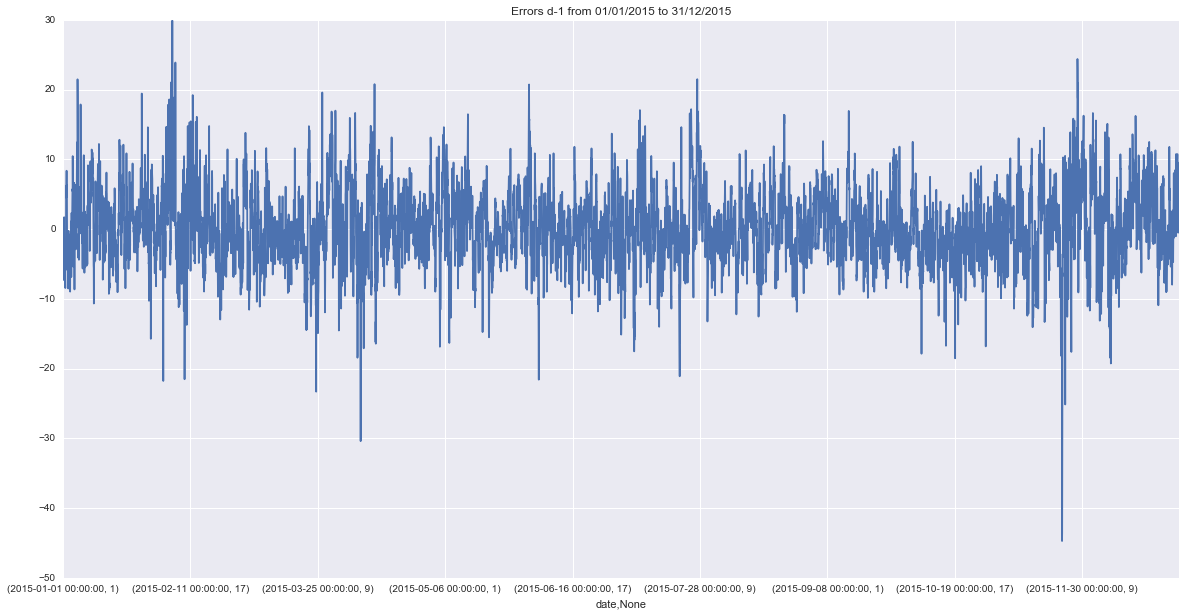

In [14]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 0, generation_ahead = 0, 
                    predict_ahead = 4, normalization = True)
randomized_params = {'kernel': ['poly'],'alpha': np.random.rand(300)*6+0.5, 'degree': np.arange(2, 7)}
model_base = KernelRidge()
modeler = Modeler(model_base = model_base, wrangler = wrangler)
modeler.run(search_params = randomized_params, n_randomized_search = 200, cv = 5, viz = 'betterVIZ.csv')

## Then let's explore another models, like Random Forest

***Warning:*** this may take more than **2 hours**.

Wrangling...
Wrangling finished. Totally take 0.12s
Searching...
Searching finished. Totally take 11819.62s
Best modeler found: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
           max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=1, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

========== Test from 01/01/2015 to 31/12/2015 ==========
D+1 MAE: 4.83521346657
D+2 MAE: 5.64657926352
D+3 MAE: 6.02094372198
D+4 MAE: 6.30748473359



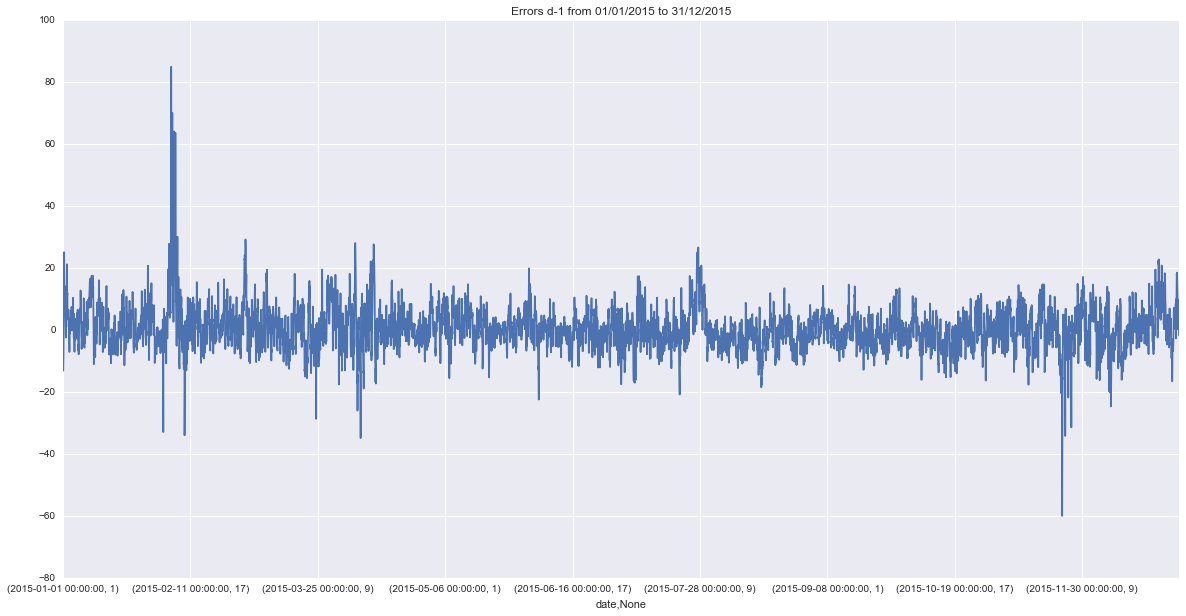

In [15]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
randomized_params = {'n_estimators': [150] ,'max_depth': np.arange(2, 20), 'min_samples_leaf': [1, 3, 10], 
                     'min_samples_split': [1, 3, 10], 'bootstrap': [True, False], 'max_features': ['log2', 'sqrt', None]}
model_base = RandomForestRegressor()
modeler = Modeler(model_base = model_base, wrangler = wrangler)
modeler.run(search_params = randomized_params, n_randomized_search = 200, cv = 5,viz = 'rf.csv')

## Try k-nearest neighbor method
This may take about 10 minutes.

Wrangling...
Wrangling finished. Totally take 0.13s
Searching...
Searching finished. Totally take 645.01s
Best modeler found: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=23, p=3,
          weights='uniform')

========== Test from 01/01/2015 to 31/12/2015 ==========
D+1 MAE: 5.17109413341
D+2 MAE: 5.84205924013
D+3 MAE: 6.20076077973
D+4 MAE: 6.39050669589



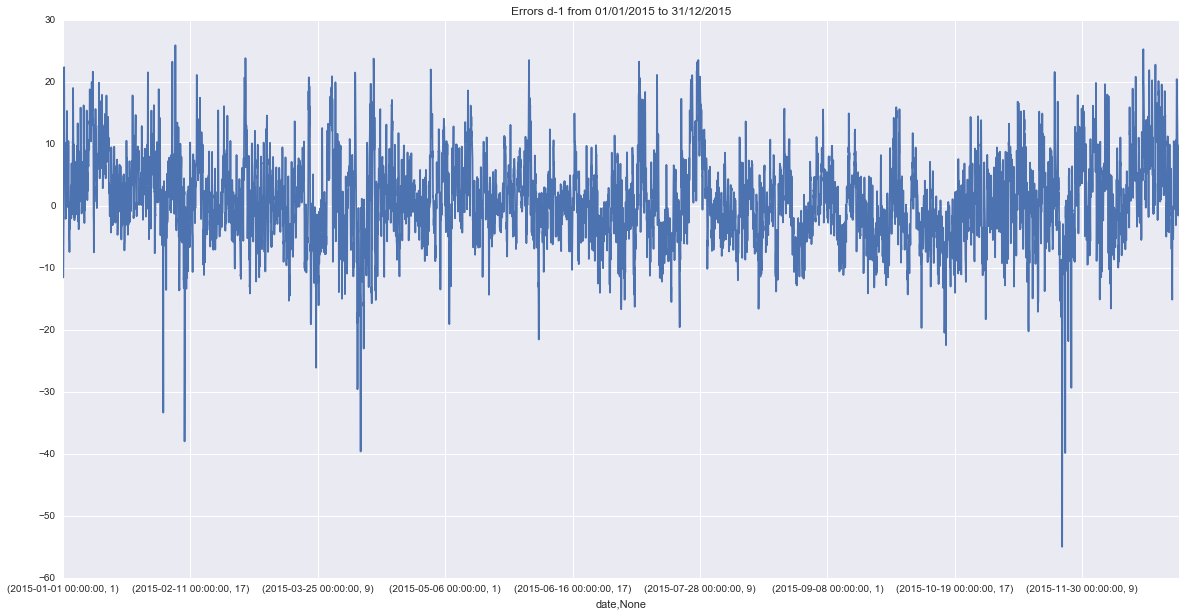

In [16]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
randomized_params = {'n_neighbors': np.arange(1, 36) ,'p':np.arange(1,11)}
model_base = KNeighborsRegressor()
modeler = Modeler(model_base = model_base, wrangler = wrangler)
modeler.run(search_params = randomized_params, n_randomized_search = 100, cv = 5, viz = 'knn.csv')

## Now, let's look at, what if we train separate 96 models on the train data, a so-called 'Wrapper'
We will find every block of code bellow will take a bit **LONG** time, even without searching.
The following tests include Kernel Ridge itself, Gradient Boosting Trees, Support Vector Machine (with different Kernels)

Note: the parameters bellow is directly based on the test data, so they may get good result, but the result should not be reliable.

In [17]:
import pandas as pd
import copy

class Wrapper(object):
    
    def __init__(self, base):
        self.base = base

    def fit(self,X,Y):
        print 'Fitting...'
        now = time.time()
        self.modeler = dict()
        for col in Y.columns:
            model = copy.deepcopy(self.base)
            model.fit(X,Y[col])
            self.modeler[col] = model
        print 'Fitting finished. Totally take %.2fs' % (time.time() - now)
        return self
        
    def predict(self,X):
        print 'Predicting...'
        now = time.time()
        output = pd.DataFrame(index = X.index)
        for col in self.modeler:
            output[col] = self.modeler[col].predict(X)
        print 'Predicting finished. Totally take %.2fs' % (time.time() - now)
        return output

## Directly check on KernelRidge.
We will find the Wrapper will slow down the performance, for about 60 times.

One reason is, I directly use for loop to calculate, and with out parallel.

Another more **IMPORTANT** reason is, for Kernel Ridge, it can get the parameters for multioutput directly. So, for the original version, it's still one model. But the Wrapper one, it has 96 models..

This is also the reason why we should not directly use Boosting Trees or SVM for our model, since they cannot train the multioutput model directly.

In [18]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
wrapper = Wrapper(KernelRidge(kernel = 'rbf', alpha = 0.54)).fit(wrangler.Xtrain,wrangler.Ytrain)
errors = wrapper.predict(wrangler.Xtest) - wrangler.Ytest
print "D+1 MAE:", errors[[i+1 for i in range(24)]].abs().mean().mean()
print "D+2 MAE:", errors[[i+25 for i in range(24)]].abs().mean().mean()
print "D+3 MAE:", errors[[i+49 for i in range(24)]].abs().mean().mean()
print "D+4 MAE:", errors[[i+73 for i in range(24)]].abs().mean().mean()

Wrangling...
Wrangling finished. Totally take 0.13s
Fitting...
Fitting finished. Totally take 6.66s
Predicting...
Predicting finished. Totally take 1.85s
D+1 MAE: 4.1363579598
D+2 MAE: 5.17440905117
D+3 MAE: 5.7822455176
D+4 MAE: 6.29380874987


In [19]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
print 'Fitting...'
now = time.time()
wrapper = KernelRidge(kernel = 'rbf', alpha = 0.54).fit(wrangler.Xtrain,wrangler.Ytrain)
print 'Fitting finished. Totally take %.2fs' % (time.time() - now)
print 'Predicting...'
now = time.time()
errors = wrapper.predict(wrangler.Xtest) - wrangler.Ytest
print 'Predicting finished. Totally take %.2fs' % (time.time() - now)
print "D+1 MAE:", errors[[i+1 for i in range(24)]].abs().mean().mean()
print "D+2 MAE:", errors[[i+25 for i in range(24)]].abs().mean().mean()
print "D+3 MAE:", errors[[i+49 for i in range(24)]].abs().mean().mean()
print "D+4 MAE:", errors[[i+73 for i in range(24)]].abs().mean().mean()

Wrangling...
Wrangling finished. Totally take 0.12s
Fitting...
Fitting finished. Totally take 0.08s
Predicting...
Predicting finished. Totally take 0.03s
D+1 MAE: 4.1363579598
D+2 MAE: 5.17440905117
D+3 MAE: 5.7822455176
D+4 MAE: 6.29380874987


## Then work on Gradient Boosting Trees and SVM

In [20]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
wrapper = Wrapper(GradientBoostingRegressor()).fit(wrangler.Xtrain,wrangler.Ytrain)
errors = wrapper.predict(wrangler.Xtest) - wrangler.Ytest
print "D+1 MAE:", errors[[i+1 for i in range(24)]].abs().mean().mean()
print "D+2 MAE:", errors[[i+25 for i in range(24)]].abs().mean().mean()
print "D+3 MAE:", errors[[i+49 for i in range(24)]].abs().mean().mean()
print "D+4 MAE:", errors[[i+73 for i in range(24)]].abs().mean().mean()

Wrangling...
Wrangling finished. Totally take 0.14s
Fitting...
Fitting finished. Totally take 531.24s
Predicting...
Predicting finished. Totally take 0.27s
D+1 MAE: 4.4334576969
D+2 MAE: 6.01863470628
D+3 MAE: 7.2462942222
D+4 MAE: 6.66190213113


In [21]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
wrapper = Wrapper(SVR(kernel='rbf')).fit(wrangler.Xtrain,wrangler.Ytrain)
errors = wrapper.predict(wrangler.Xtest) - wrangler.Ytest
print "D+1 MAE:", errors[[i+1 for i in range(24)]].abs().mean().mean()
print "D+2 MAE:", errors[[i+25 for i in range(24)]].abs().mean().mean()
print "D+3 MAE:", errors[[i+49 for i in range(24)]].abs().mean().mean()
print "D+4 MAE:", errors[[i+73 for i in range(24)]].abs().mean().mean()

Wrangling...
Wrangling finished. Totally take 0.19s
Fitting...
Fitting finished. Totally take 76.19s
Predicting...
Predicting finished. Totally take 24.28s
D+1 MAE: 4.7155527454
D+2 MAE: 5.8506117822
D+3 MAE: 6.31190012739
D+4 MAE: 6.50416720207


In [22]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
wrapper = Wrapper(SVR(kernel='linear')).fit(wrangler.Xtrain,wrangler.Ytrain)
errors = wrapper.predict(wrangler.Xtest) - wrangler.Ytest
print "D+1 MAE:", errors[[i+1 for i in range(24)]].abs().mean().mean()
print "D+2 MAE:", errors[[i+25 for i in range(24)]].abs().mean().mean()
print "D+3 MAE:", errors[[i+49 for i in range(24)]].abs().mean().mean()
print "D+4 MAE:", errors[[i+73 for i in range(24)]].abs().mean().mean()

Wrangling...
Wrangling finished. Totally take 0.14s
Fitting...
Fitting finished. Totally take 142.22s
Predicting...
Predicting finished. Totally take 22.41s
D+1 MAE: 4.15756021849
D+2 MAE: 5.3960130443
D+3 MAE: 5.88102264429
D+4 MAE: 6.33370188799


In [23]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
wrapper = Wrapper(SVR(kernel='poly',degree=3)).fit(wrangler.Xtrain,wrangler.Ytrain)
errors = wrapper.predict(wrangler.Xtest) - wrangler.Ytest
print "D+1 MAE:", errors[[i+1 for i in range(24)]].abs().mean().mean()
print "D+2 MAE:", errors[[i+25 for i in range(24)]].abs().mean().mean()
print "D+3 MAE:", errors[[i+49 for i in range(24)]].abs().mean().mean()
print "D+4 MAE:", errors[[i+73 for i in range(24)]].abs().mean().mean()

Wrangling...
Wrangling finished. Totally take 0.27s
Fitting...
Fitting finished. Totally take 72.97s
Predicting...
Predicting finished. Totally take 22.57s
D+1 MAE: 6.79677678375
D+2 MAE: 7.48505593846
D+3 MAE: 7.87538864924
D+4 MAE: 8.02107064497


In [24]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
wrapper = Wrapper(SVR(kernel='poly',degree=2)).fit(wrangler.Xtrain,wrangler.Ytrain)
errors = wrapper.predict(wrangler.Xtest) - wrangler.Ytest
print "D+1 MAE:", errors[[i+1 for i in range(24)]].abs().mean().mean()
print "D+2 MAE:", errors[[i+25 for i in range(24)]].abs().mean().mean()
print "D+3 MAE:", errors[[i+49 for i in range(24)]].abs().mean().mean()
print "D+4 MAE:", errors[[i+73 for i in range(24)]].abs().mean().mean()

Wrangling...
Wrangling finished. Totally take 0.17s
Fitting...
Fitting finished. Totally take 73.56s
Predicting...
Predicting finished. Totally take 22.51s
D+1 MAE: 8.6195663498
D+2 MAE: 8.86540796145
D+3 MAE: 8.97903462542
D+4 MAE: 8.93448889006


In [25]:
wrangler = Wrangler(spot = pd.read_csv('data/spot.csv', parse_dates = True, index_col = 0, dayfirst = True), 
                    consumption = pd.read_csv('data/consumption.csv',parse_dates = True, index_col = 0, dayfirst = True),
                    pro_generation = pd.read_csv('data/pro_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    non_generation = pd.read_csv('data/non_generation.csv',parse_dates = True, index_col = 0, dayfirst = True), 
                    train_period = ['2012-01-01', '2014-12-31'], test_period = ['2015-01-01', '2015-12-31'],
                    spot_ahead = 7, consumption_ahead = 1, generation_ahead = 1, 
                    predict_ahead = 4, normalization = True)
wrapper = Wrapper(SVR(kernel='poly',degree=4)).fit(wrangler.Xtrain,wrangler.Ytrain)
errors = wrapper.predict(wrangler.Xtest) - wrangler.Ytest
print "D+1 MAE:", errors[[i+1 for i in range(24)]].abs().mean().mean()
print "D+2 MAE:", errors[[i+25 for i in range(24)]].abs().mean().mean()
print "D+3 MAE:", errors[[i+49 for i in range(24)]].abs().mean().mean()
print "D+4 MAE:", errors[[i+73 for i in range(24)]].abs().mean().mean()

Wrangling...
Wrangling finished. Totally take 0.18s
Fitting...
Fitting finished. Totally take 71.36s
Predicting...
Predicting finished. Totally take 22.74s
D+1 MAE: 8.41939750817
D+2 MAE: 8.66164971891
D+3 MAE: 8.87347521073
D+4 MAE: 9.06502569716
